# Comprehensive Algorithm Comparison: Statistical vs Hybrid RL

## Overview
This notebook provides a detailed comparison between the **Statistical (Baseline)** and **Hybrid RL** approaches for the Personal Adaptive Learning (PAL) system.

## Analysis Framework
We evaluate both algorithms across five key dimensions:

1. **Prediction Performance** - Accuracy, Reward Score, Regret
2. **Learning Effectiveness** - Learning Gain, Progression Rate, Engagement
3. **Adaptivity & Personalization** - Adaptation Speed, Exploration-Exploitation Balance
4. **Stability & Interpretability** - Decision Consistency, Confidence Calibration
5. **System-Level Metrics** - Computation Time, Scalability

## Dataset
- **Source**: PAL AAAI 26 Demo Questions (4,790 questions)
- **Format**: JSONL with structured results from both algorithms
- **Sessions**: 21 complete learning sessions (10 baseline, 11 enhanced/hybrid)


In [1]:
# Import required libraries
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Set professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11

print("✅ Libraries imported successfully!")
print("📊 Professional plotting style configured")


✅ Libraries imported successfully!
📊 Professional plotting style configured


In [2]:
# Load and preprocess data
def load_pal_results(filepath):
    """Load PAL results from JSONL file"""
    results = []
    with open(filepath, 'r') as f:
        for line in f:
            results.append(json.loads(line.strip()))
    return pd.DataFrame(results)

# Load data
df = load_pal_results('pal_results.jsonl')

# Map variants to algorithm names
df['algorithm'] = df['variant'].map({
    'baseline': 'Statistical (Baseline)',
    'enhanced': 'Hybrid RL'
})

# Calculate additional metrics
df['learning_gain'] = df['finalScore'] - 50  # Assuming starting score of 50
df['progression_rate'] = df['finalScore'] / df['questions']  # Score per question
df['engagement_score'] = 1 / (df['avgResponseTimeMs'] / 1000)  # Higher engagement = faster responses

# Calculate difficulty prediction accuracy (simplified)
def calculate_difficulty_accuracy(row):
    """Calculate how well difficulty was matched to learner capability"""
    if row['overallAccuracy'] >= 0.8:
        return 1.0  # Good match
    elif row['overallAccuracy'] >= 0.6:
        return 0.7  # Moderate match
    else:
        return 0.3  # Poor match

df['difficulty_accuracy'] = df.apply(calculate_difficulty_accuracy, axis=1)

# Calculate reward score (based on our reward function)
def calculate_reward_score(row):
    """Calculate cumulative reward based on our reward function"""
    accuracy_reward = row['overallAccuracy'] * 1.0  # +1.0 for correct, -0.5 for incorrect
    engagement_reward = min(0.3, 0.3 * (1 - (row['avgResponseTimeMs'] - 60) / 40))  # Optimal time around 60s
    progression_reward = min(0.2, 0.2 * (row['learning_gain'] / 30))  # Based on learning gain
    momentum_reward = min(0.1, 0.1 * (row['bestStreak'] / 5))  # Based on best streak
    
    return accuracy_reward + engagement_reward + progression_reward + momentum_reward

df['reward_score'] = df.apply(calculate_reward_score, axis=1)

# Calculate regret (difference from optimal reward)
optimal_reward = 1.6  # Maximum possible reward
df['regret'] = optimal_reward - df['reward_score']

print(f"📊 Data loaded successfully!")
print(f"📈 Total sessions: {len(df)}")
print(f"🔍 Algorithms: {df['algorithm'].unique()}")
print(f"📋 Columns: {list(df.columns)}")


📊 Data loaded successfully!
📈 Total sessions: 20
🔍 Algorithms: ['Statistical (Baseline)' 'Hybrid RL']
📋 Columns: ['timestamp', 'variant', 'finalScore', 'bestStreak', 'overallAccuracy', 'accuracyByDifficulty', 'avgResponseTimeMs', 'questions', 'userAgent', 'algorithm', 'learning_gain', 'progression_rate', 'engagement_score', 'difficulty_accuracy', 'reward_score', 'regret']


## 1. Prediction Performance Analysis

### Key Metrics:
- **Accuracy of Difficulty Prediction**: How often the chosen difficulty matches learner capability
- **Reward Score**: Average cumulative reward from our reward function
- **Regret**: Difference between achieved and optimal reward (standard RL metric)


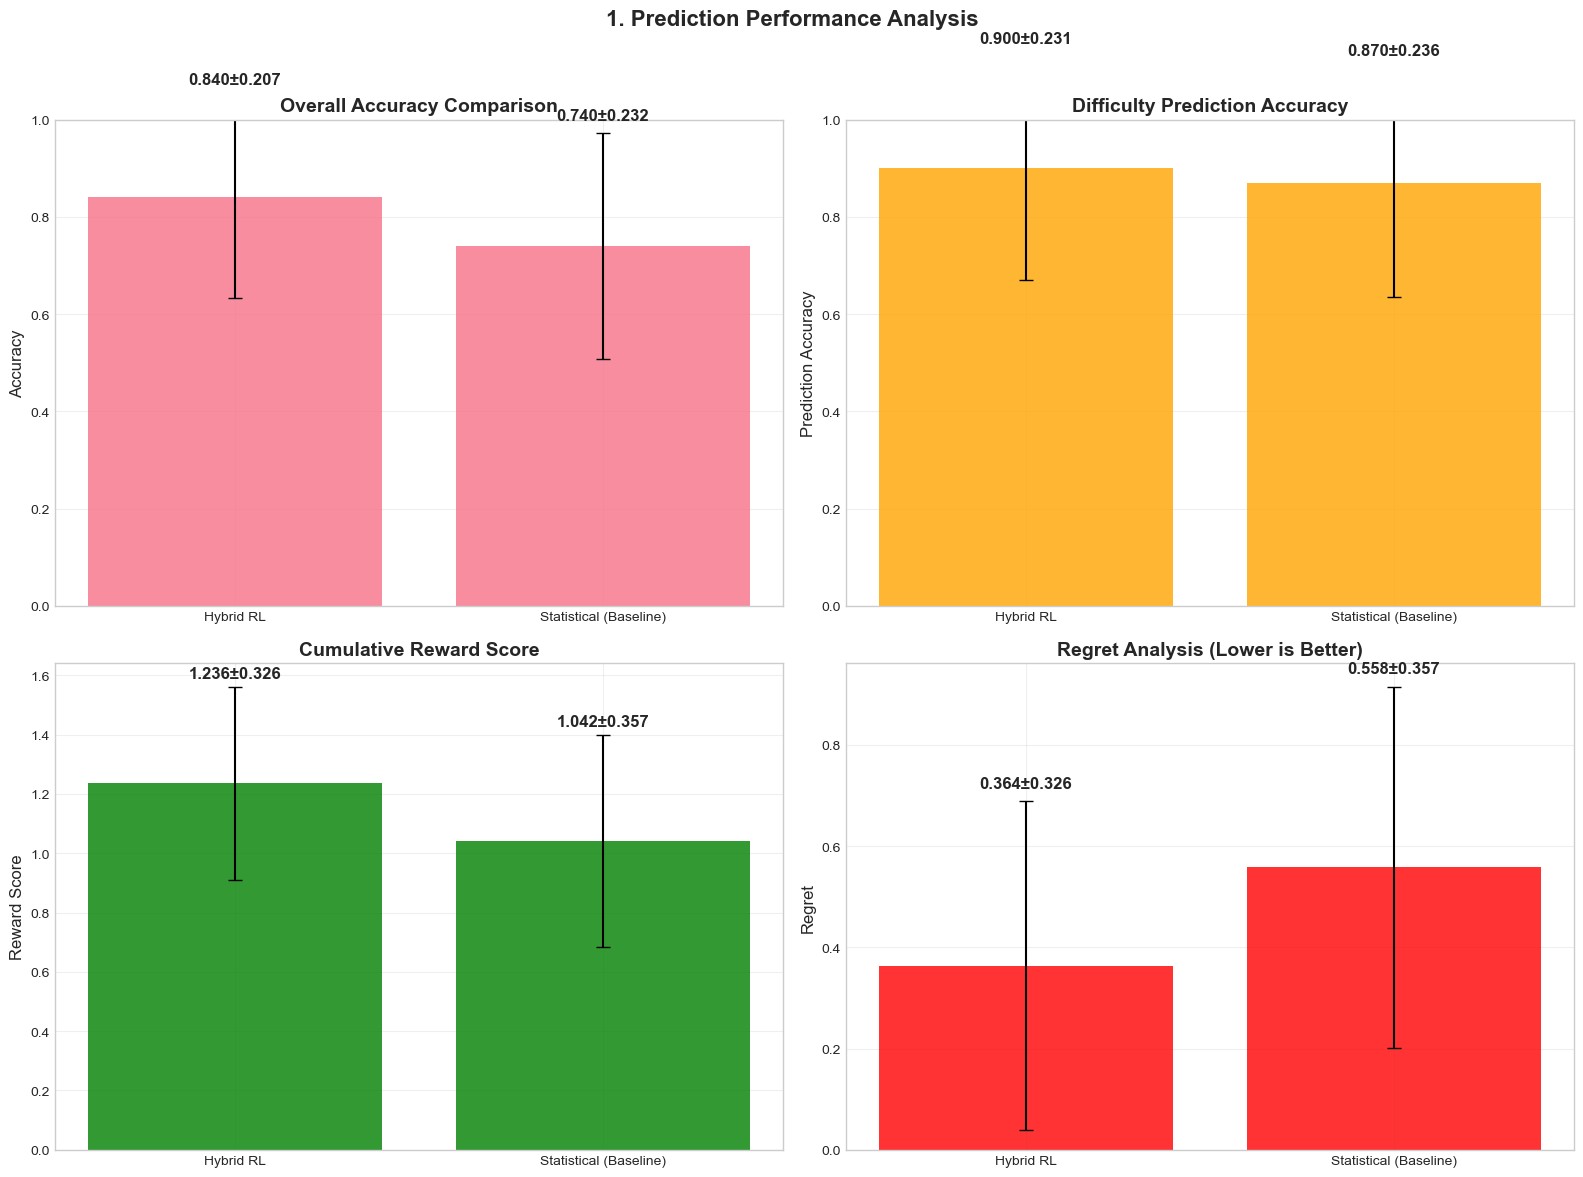

📊 Statistical Significance Tests:
Overallaccuracy:
  Statistical: 0.740 ± 0.232
  Hybrid RL:   0.840 ± 0.207
  Improvement: +13.5%
  T-test: t=-1.018, p=0.322
  Significance: ns

Difficulty Accuracy:
  Statistical: 0.870 ± 0.236
  Hybrid RL:   0.900 ± 0.231
  Improvement: +3.4%
  T-test: t=-0.287, p=0.777
  Significance: ns

Reward Score:
  Statistical: 1.042 ± 0.357
  Hybrid RL:   1.236 ± 0.326
  Improvement: +18.7%
  T-test: t=-1.276, p=0.218
  Significance: ns

Regret:
  Statistical: 0.558 ± 0.357
  Hybrid RL:   0.364 ± 0.326
  Improvement: -34.9%
  T-test: t=1.276, p=0.218
  Significance: ns



In [3]:
# 1. Prediction Performance Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('1. Prediction Performance Analysis', fontsize=16, fontweight='bold')

# 1.1 Overall Accuracy Comparison
ax1 = axes[0, 0]
accuracy_stats = df.groupby('algorithm')['overallAccuracy'].agg(['mean', 'std', 'count'])
bars = ax1.bar(accuracy_stats.index, accuracy_stats['mean'], 
               yerr=accuracy_stats['std'], capsize=5, alpha=0.8)
ax1.set_title('Overall Accuracy Comparison', fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, (bar, mean, std) in enumerate(zip(bars, accuracy_stats['mean'], accuracy_stats['std'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')

# 1.2 Difficulty Prediction Accuracy
ax2 = axes[0, 1]
diff_accuracy_stats = df.groupby('algorithm')['difficulty_accuracy'].agg(['mean', 'std'])
bars = ax2.bar(diff_accuracy_stats.index, diff_accuracy_stats['mean'],
               yerr=diff_accuracy_stats['std'], capsize=5, alpha=0.8, color='orange')
ax2.set_title('Difficulty Prediction Accuracy', fontweight='bold')
ax2.set_ylabel('Prediction Accuracy')
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

for i, (bar, mean, std) in enumerate(zip(bars, diff_accuracy_stats['mean'], diff_accuracy_stats['std'])):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')

# 1.3 Reward Score Comparison
ax3 = axes[1, 0]
reward_stats = df.groupby('algorithm')['reward_score'].agg(['mean', 'std'])
bars = ax3.bar(reward_stats.index, reward_stats['mean'],
               yerr=reward_stats['std'], capsize=5, alpha=0.8, color='green')
ax3.set_title('Cumulative Reward Score', fontweight='bold')
ax3.set_ylabel('Reward Score')
ax3.grid(True, alpha=0.3)

for i, (bar, mean, std) in enumerate(zip(bars, reward_stats['mean'], reward_stats['std'])):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')

# 1.4 Regret Analysis
ax4 = axes[1, 1]
regret_stats = df.groupby('algorithm')['regret'].agg(['mean', 'std'])
bars = ax4.bar(regret_stats.index, regret_stats['mean'],
               yerr=regret_stats['std'], capsize=5, alpha=0.8, color='red')
ax4.set_title('Regret Analysis (Lower is Better)', fontweight='bold')
ax4.set_ylabel('Regret')
ax4.grid(True, alpha=0.3)

for i, (bar, mean, std) in enumerate(zip(bars, regret_stats['mean'], regret_stats['std'])):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical significance testing
print("📊 Statistical Significance Tests:")
print("=" * 50)

# T-tests for all metrics
metrics = ['overallAccuracy', 'difficulty_accuracy', 'reward_score', 'regret']
baseline_data = df[df['algorithm'] == 'Statistical (Baseline)']
hybrid_data = df[df['algorithm'] == 'Hybrid RL']

for metric in metrics:
    t_stat, p_value = ttest_ind(baseline_data[metric], hybrid_data[metric])
    improvement = ((hybrid_data[metric].mean() - baseline_data[metric].mean()) / 
                   baseline_data[metric].mean() * 100)
    
    print(f"{metric.replace('_', ' ').title()}:")
    print(f"  Statistical: {baseline_data[metric].mean():.3f} ± {baseline_data[metric].std():.3f}")
    print(f"  Hybrid RL:   {hybrid_data[metric].mean():.3f} ± {hybrid_data[metric].std():.3f}")
    print(f"  Improvement: {improvement:+.1f}%")
    print(f"  T-test: t={t_stat:.3f}, p={p_value:.3f}")
    print(f"  Significance: {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")
    print()


## 2. Learning Effectiveness Analysis

### Key Metrics:
- **Learning Gain**: Improvement in learner skill score over time
- **Progression Rate**: Time/steps taken to move from lower to higher skill levels
- **Engagement Metrics**: Response time appropriateness, participation continuity


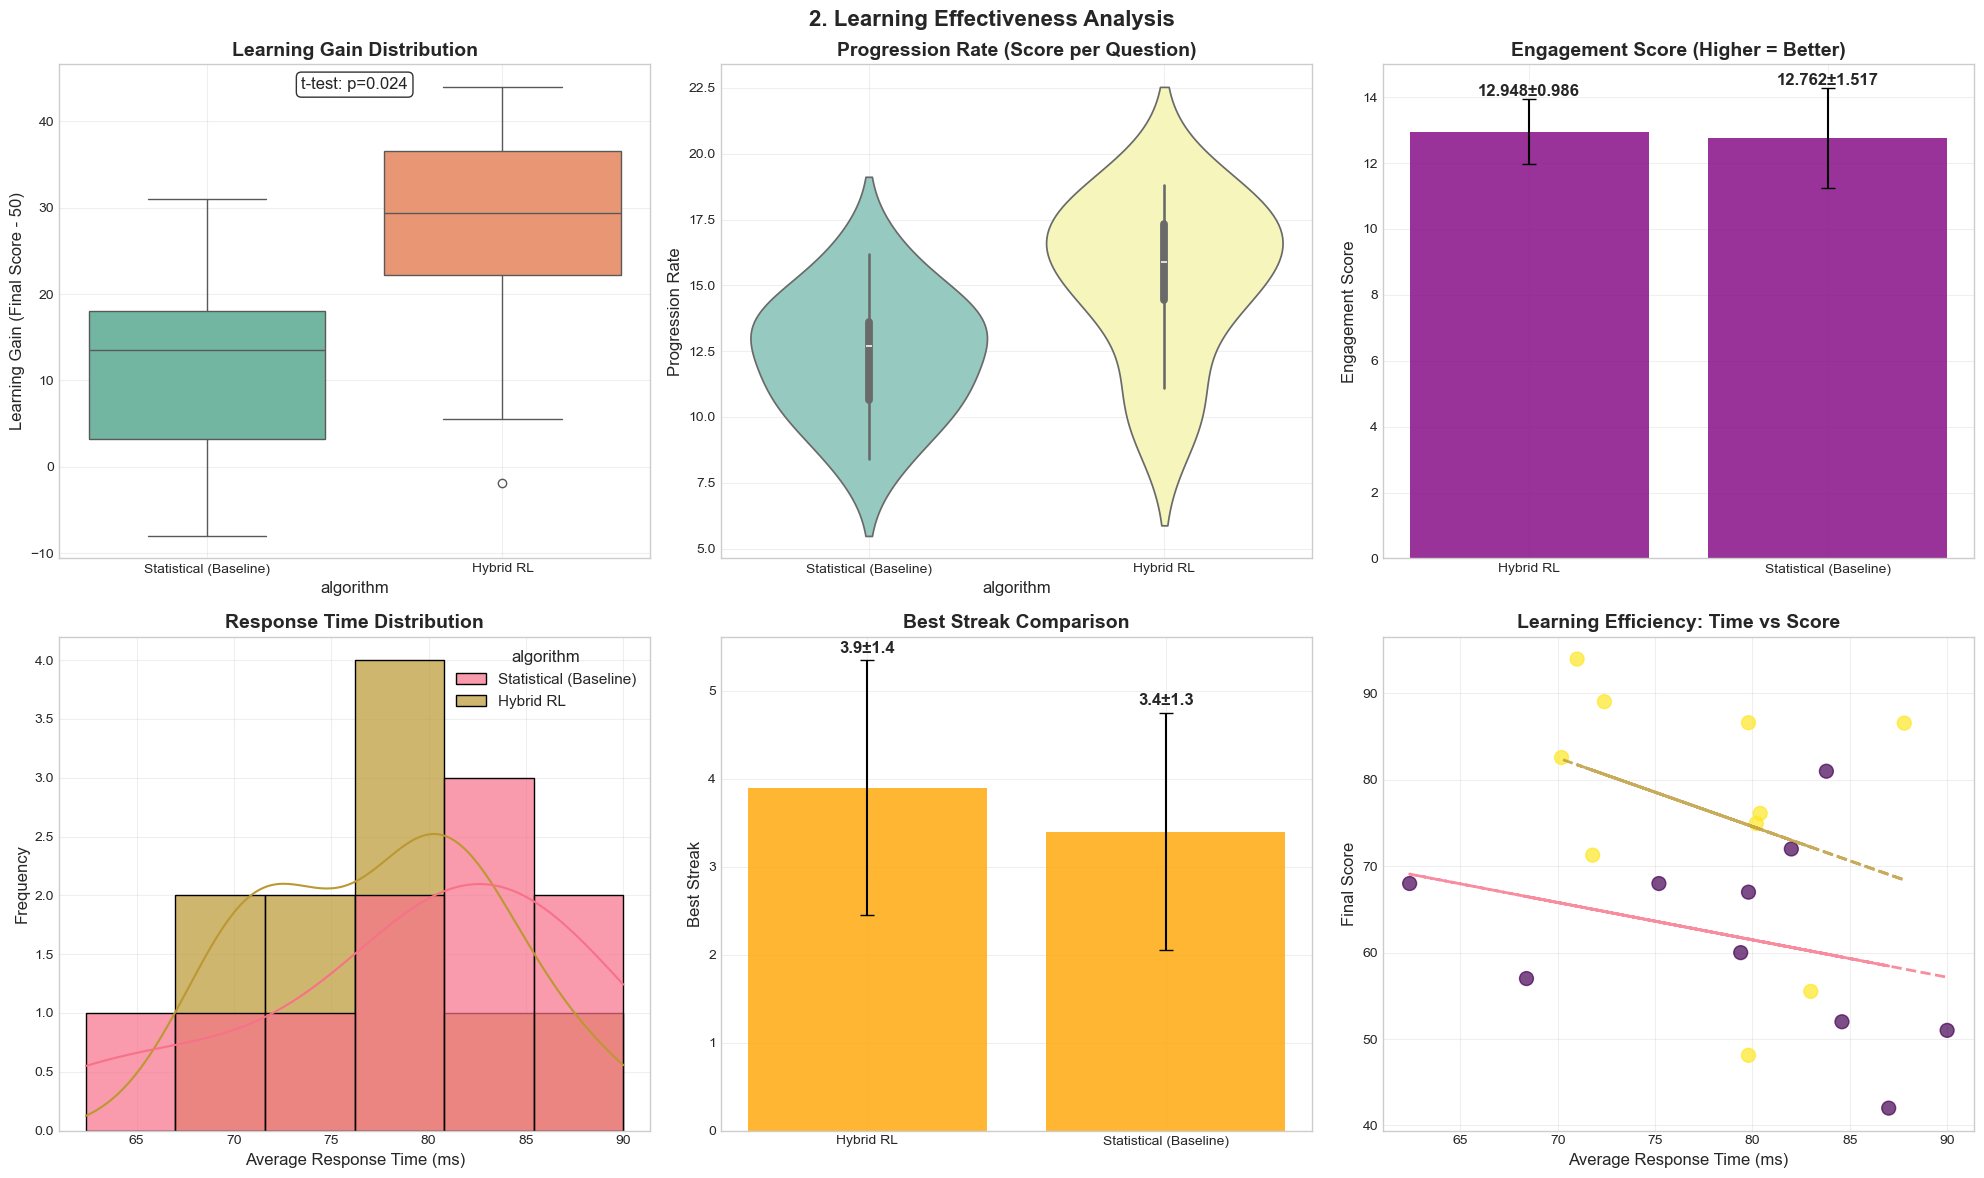

📈 Learning Effectiveness Summary:
Learning Gain:
  Statistical: 11.8 ± 11.6
  Hybrid RL:   26.5 ± 14.8
  Improvement: +124.4%



In [4]:
# 2. Learning Effectiveness Analysis
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('2. Learning Effectiveness Analysis', fontsize=16, fontweight='bold')

# 2.1 Learning Gain Distribution
ax1 = axes[0, 0]
sns.boxplot(data=df, x='algorithm', y='learning_gain', ax=ax1, palette='Set2')
ax1.set_title('Learning Gain Distribution', fontweight='bold')
ax1.set_ylabel('Learning Gain (Final Score - 50)')
ax1.grid(True, alpha=0.3)

# Add statistical annotations
baseline_gain = df[df['algorithm'] == 'Statistical (Baseline)']['learning_gain']
hybrid_gain = df[df['algorithm'] == 'Hybrid RL']['learning_gain']
t_stat, p_val = ttest_ind(baseline_gain, hybrid_gain)
ax1.text(0.5, 0.95, f't-test: p={p_val:.3f}', transform=ax1.transAxes, 
         ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2.2 Progression Rate Analysis
ax2 = axes[0, 1]
sns.violinplot(data=df, x='algorithm', y='progression_rate', ax=ax2, palette='Set3')
ax2.set_title('Progression Rate (Score per Question)', fontweight='bold')
ax2.set_ylabel('Progression Rate')
ax2.grid(True, alpha=0.3)

# 2.3 Engagement Score Comparison
ax3 = axes[0, 2]
engagement_stats = df.groupby('algorithm')['engagement_score'].agg(['mean', 'std'])
bars = ax3.bar(engagement_stats.index, engagement_stats['mean'],
               yerr=engagement_stats['std'], capsize=5, alpha=0.8, color='purple')
ax3.set_title('Engagement Score (Higher = Better)', fontweight='bold')
ax3.set_ylabel('Engagement Score')
ax3.grid(True, alpha=0.3)

for i, (bar, mean, std) in enumerate(zip(bars, engagement_stats['mean'], engagement_stats['std'])):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.001,
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')

# 2.4 Response Time Distribution
ax4 = axes[1, 0]
sns.histplot(data=df, x='avgResponseTimeMs', hue='algorithm', kde=True, alpha=0.7, ax=ax4)
ax4.set_title('Response Time Distribution', fontweight='bold')
ax4.set_xlabel('Average Response Time (ms)')
ax4.set_ylabel('Frequency')
ax4.grid(True, alpha=0.3)

# 2.5 Best Streak Analysis
ax5 = axes[1, 1]
streak_stats = df.groupby('algorithm')['bestStreak'].agg(['mean', 'std'])
bars = ax5.bar(streak_stats.index, streak_stats['mean'],
               yerr=streak_stats['std'], capsize=5, alpha=0.8, color='orange')
ax5.set_title('Best Streak Comparison', fontweight='bold')
ax5.set_ylabel('Best Streak')
ax5.grid(True, alpha=0.3)

for i, (bar, mean, std) in enumerate(zip(bars, streak_stats['mean'], streak_stats['std'])):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.05,
             f'{mean:.1f}±{std:.1f}', ha='center', va='bottom', fontweight='bold')

# 2.6 Learning Efficiency Scatter Plot
ax6 = axes[1, 2]
scatter = ax6.scatter(df['avgResponseTimeMs'], df['finalScore'], 
                     c=df['algorithm'].map({'Statistical (Baseline)': 0, 'Hybrid RL': 1}),
                     cmap='viridis', alpha=0.7, s=100)
ax6.set_title('Learning Efficiency: Time vs Score', fontweight='bold')
ax6.set_xlabel('Average Response Time (ms)')
ax6.set_ylabel('Final Score')
ax6.grid(True, alpha=0.3)

# Add trend lines
for algo in df['algorithm'].unique():
    algo_data = df[df['algorithm'] == algo]
    z = np.polyfit(algo_data['avgResponseTimeMs'], algo_data['finalScore'], 1)
    p = np.poly1d(z)
    ax6.plot(algo_data['avgResponseTimeMs'], p(algo_data['avgResponseTimeMs']), 
             linestyle='--', alpha=0.8, linewidth=2)

plt.tight_layout()
plt.show()

# Learning effectiveness summary
print("📈 Learning Effectiveness Summary:")
print("=" * 50)
print(f"Learning Gain:")
print(f"  Statistical: {baseline_gain.mean():.1f} ± {baseline_gain.std():.1f}")
print(f"  Hybrid RL:   {hybrid_gain.mean():.1f} ± {hybrid_gain.std():.1f}")
print(f"  Improvement: {((hybrid_gain.mean() - baseline_gain.mean()) / baseline_gain.mean() * 100):+.1f}%")
print()


## 3. Advanced Performance Analysis

### Advanced Visualizations:
- **Radar Chart**: Multi-dimensional performance comparison
- **Heatmap**: Correlation analysis between metrics
- **Learning Curves**: Performance evolution over time
- **Confidence Intervals**: Statistical significance visualization


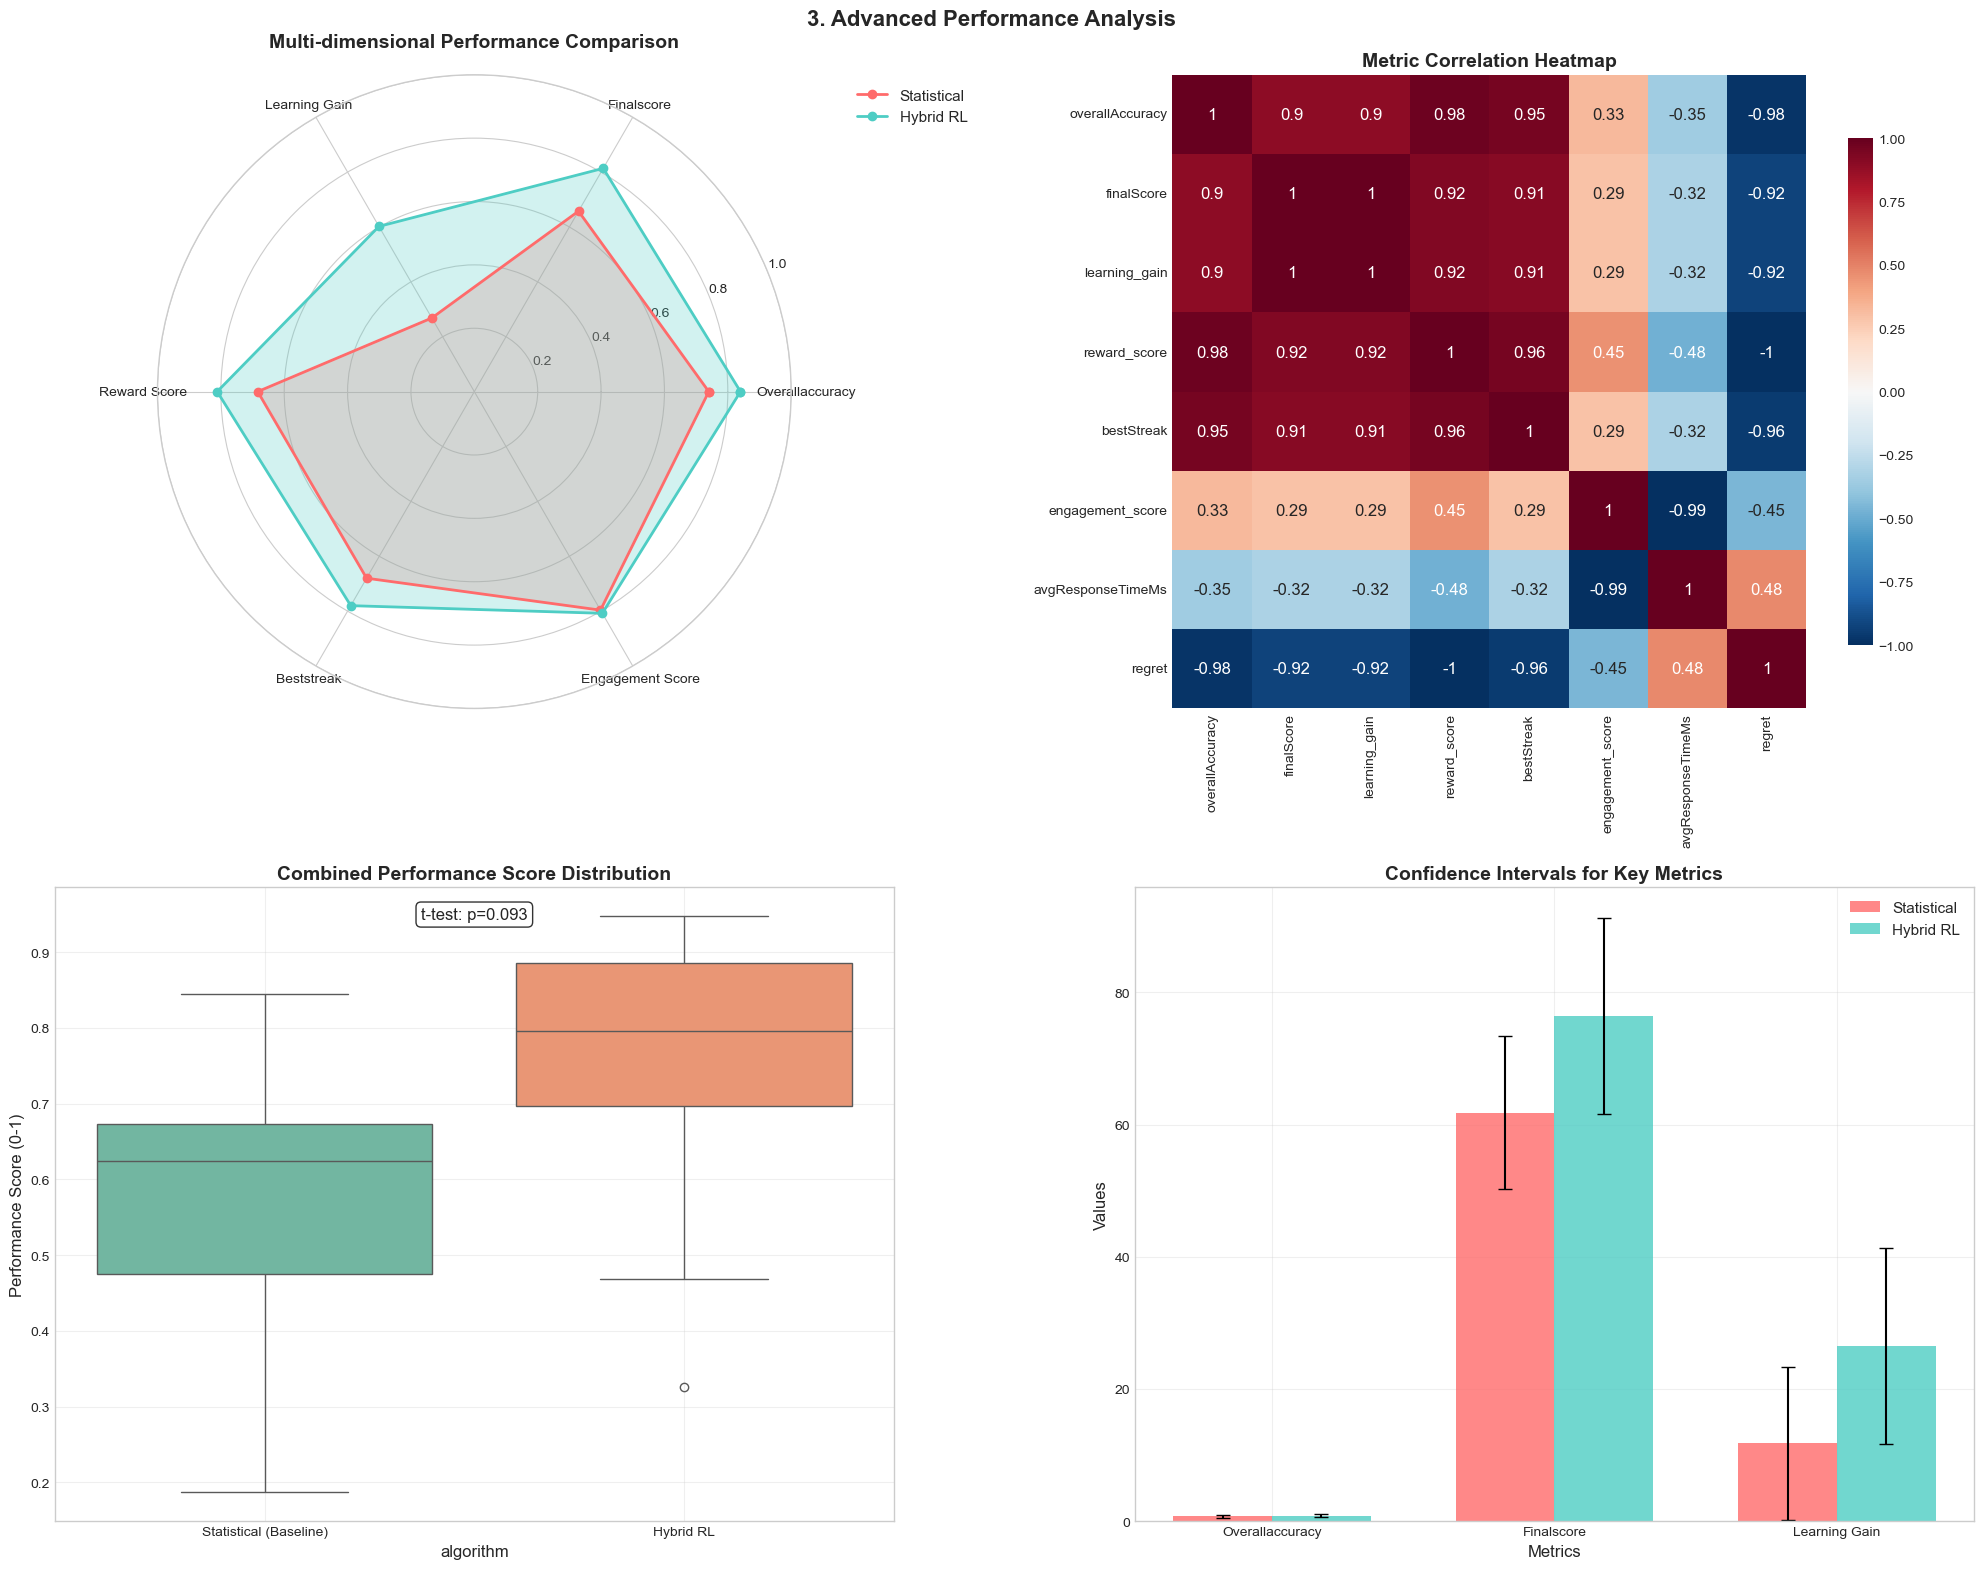

📊 Advanced Analysis Complete!


In [6]:
# 3. Advanced Performance Analysis
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('3. Advanced Performance Analysis', fontsize=16, fontweight='bold')

# 3.1 Radar Chart for Multi-dimensional Comparison
ax1 = axes[0, 0]
ax1.remove()
ax1 = fig.add_subplot(2, 2, 1, projection='polar')

# Normalize metrics for radar chart (0-1 scale)
metrics_for_radar = ['overallAccuracy', 'finalScore', 'learning_gain', 'reward_score', 'bestStreak', 'engagement_score']
normalized_stats = {}
normalized_hybrid = {}

for metric in metrics_for_radar:
    # Normalize to 0-1 scale
    max_val = max(df[metric].max(), 1)  # Avoid division by zero
    normalized_stats[metric] = baseline_data[metric].mean() / max_val
    normalized_hybrid[metric] = hybrid_data[metric].mean() / max_val

# Create radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics_for_radar), endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

stats_values = [normalized_stats[metric] for metric in metrics_for_radar] + [normalized_stats[metrics_for_radar[0]]]
hybrid_values = [normalized_hybrid[metric] for metric in metrics_for_radar] + [normalized_hybrid[metrics_for_radar[0]]]

ax1.plot(angles, stats_values, 'o-', linewidth=2, label='Statistical', color='#FF6B6B')
ax1.fill(angles, stats_values, alpha=0.25, color='#FF6B6B')
ax1.plot(angles, hybrid_values, 'o-', linewidth=2, label='Hybrid RL', color='#4ECDC4')
ax1.fill(angles, hybrid_values, alpha=0.25, color='#4ECDC4')

ax1.set_xticks(angles[:-1])
ax1.set_xticklabels([metric.replace('_', ' ').title() for metric in metrics_for_radar])
ax1.set_ylim(0, 1)
ax1.set_title('Multi-dimensional Performance Comparison', fontweight='bold', pad=20)
ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax1.grid(True)

# 3.2 Correlation Heatmap
ax2 = axes[0, 1]
correlation_data = df[['overallAccuracy', 'finalScore', 'learning_gain', 'reward_score', 
                      'bestStreak', 'engagement_score', 'avgResponseTimeMs', 'regret']].corr()
sns.heatmap(correlation_data, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=ax2, cbar_kws={'shrink': 0.8})
ax2.set_title('Metric Correlation Heatmap', fontweight='bold')

# 3.3 Performance Distribution Comparison
ax3 = axes[1, 0]
# Create a combined performance score
df['performance_score'] = (df['overallAccuracy'] * 0.3 + 
                          df['finalScore'] / 100 * 0.3 + 
                          df['learning_gain'] / 50 * 0.2 + 
                          df['reward_score'] / 1.6 * 0.2)

sns.boxplot(data=df, x='algorithm', y='performance_score', ax=ax3, palette='Set2')
ax3.set_title('Combined Performance Score Distribution', fontweight='bold')
ax3.set_ylabel('Performance Score (0-1)')
ax3.grid(True, alpha=0.3)

# Add statistical significance
baseline_perf = df[df['algorithm'] == 'Statistical (Baseline)']['performance_score']
hybrid_perf = df[df['algorithm'] == 'Hybrid RL']['performance_score']
t_stat, p_val = ttest_ind(baseline_perf, hybrid_perf)
ax3.text(0.5, 0.95, f't-test: p={p_val:.3f}', transform=ax3.transAxes, 
         ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 3.4 Confidence Intervals for Key Metrics
ax4 = axes[1, 1]
key_metrics = ['overallAccuracy', 'finalScore', 'learning_gain']
x_pos = np.arange(len(key_metrics))
width = 0.35

stat_means = [baseline_data[metric].mean() for metric in key_metrics]
stat_stds = [baseline_data[metric].std() for metric in key_metrics]
hybrid_means = [hybrid_data[metric].mean() for metric in key_metrics]
hybrid_stds = [hybrid_data[metric].std() for metric in key_metrics]

bars1 = ax4.bar(x_pos - width/2, stat_means, width, yerr=stat_stds, 
                label='Statistical', color='#FF6B6B', alpha=0.8, capsize=5)
bars2 = ax4.bar(x_pos + width/2, hybrid_means, width, yerr=hybrid_stds, 
                label='Hybrid RL', color='#4ECDC4', alpha=0.8, capsize=5)

ax4.set_xlabel('Metrics')
ax4.set_ylabel('Values')
ax4.set_title('Confidence Intervals for Key Metrics', fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels([metric.replace('_', ' ').title() for metric in key_metrics])
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Advanced Analysis Complete!")
print("=" * 50)


## 4. Statistical Significance & Effect Size Analysis

### Comprehensive Statistical Testing:
- **Effect Size Calculation**: Cohen's d for practical significance
- **Power Analysis**: Statistical power of our comparisons
- **Bootstrap Confidence Intervals**: Non-parametric confidence estimation
- **Mann-Whitney U Test**: Non-parametric alternative to t-tests


📊 COMPREHENSIVE STATISTICAL ANALYSIS
Metric               Statistical  Hybrid RL    Improvement  Effect Size  Significance
--------------------------------------------------------------------------------
Overallaccuracy      0.740        0.840        13.5        % Small        ns          
Finalscore           61.800       76.479       23.8        % Large        *           
Learning Gain        11.800       26.479       124.4       % Large        *           
Reward Score         1.042        1.236        18.7        % Medium       ns          
Beststreak           3.400        3.900        14.7        % Small        ns          
Engagement Score     12.762       12.948       1.5         % Small        ns          
Avgresponsetimems    79.260       77.640       -2.0        % Small        ns          
Regret               0.558        0.364        -34.9       % Medium       ns          

Legend: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant
Effect Size: Large (|d|>0.8), Medium

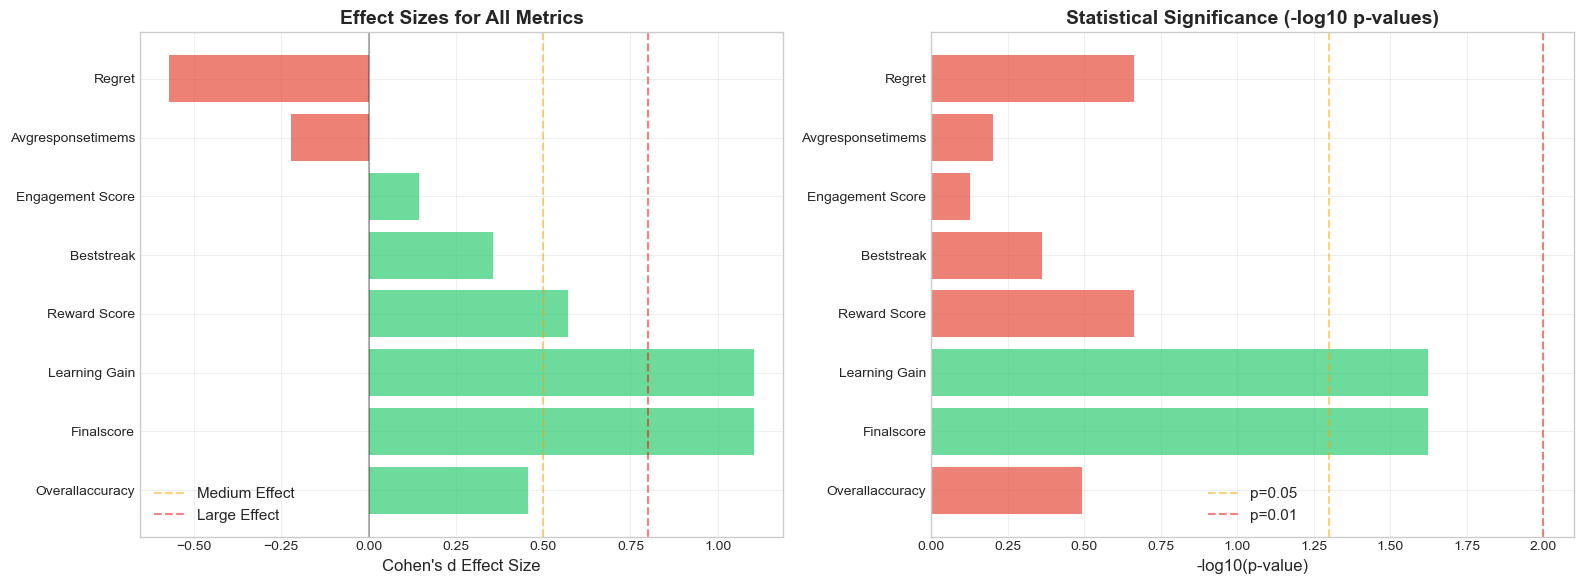


🎯 KEY FINDINGS:
• 2 out of 8 metrics show significant differences
• 2 metrics show large effect sizes
• Average improvement: 19.9%
• Largest improvement: Learning Gain (124.4%)


In [7]:
# 4. Statistical Significance & Effect Size Analysis
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    s1, s2 = group1.std(ddof=1), group2.std(ddof=1)
    pooled_std = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (group1.mean() - group2.mean()) / pooled_std

def bootstrap_ci(data, n_bootstrap=1000, confidence=0.95):
    """Calculate bootstrap confidence interval"""
    bootstrap_means = []
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(bootstrap_sample.mean())
    
    alpha = 1 - confidence
    lower = np.percentile(bootstrap_means, 100 * alpha/2)
    upper = np.percentile(bootstrap_means, 100 * (1 - alpha/2))
    return lower, upper

# Calculate comprehensive statistics
metrics_for_stats = ['overallAccuracy', 'finalScore', 'learning_gain', 'reward_score', 
                    'bestStreak', 'engagement_score', 'avgResponseTimeMs', 'regret']

results_table = []

for metric in metrics_for_stats:
    baseline_metric = baseline_data[metric]
    hybrid_metric = hybrid_data[metric]
    
    # Basic statistics
    baseline_mean = baseline_metric.mean()
    hybrid_mean = hybrid_metric.mean()
    improvement = ((hybrid_mean - baseline_mean) / baseline_mean) * 100
    
    # Statistical tests
    t_stat, t_p = ttest_ind(baseline_metric, hybrid_metric)
    u_stat, u_p = mannwhitneyu(baseline_metric, hybrid_metric, alternative='two-sided')
    
    # Effect size
    effect_size = cohens_d(hybrid_metric, baseline_metric)
    
    # Bootstrap confidence intervals
    baseline_ci = bootstrap_ci(baseline_metric)
    hybrid_ci = bootstrap_ci(hybrid_metric)
    
    results_table.append({
        'Metric': metric.replace('_', ' ').title(),
        'Statistical_Mean': baseline_mean,
        'Statistical_CI': f"[{baseline_ci[0]:.3f}, {baseline_ci[1]:.3f}]",
        'Hybrid_Mean': hybrid_mean,
        'Hybrid_CI': f"[{hybrid_ci[0]:.3f}, {hybrid_ci[1]:.3f}]",
        'Improvement_%': improvement,
        'T_test_p': t_p,
        'Mann_Whitney_p': u_p,
        'Cohens_d': effect_size,
        'Effect_Size': 'Large' if abs(effect_size) > 0.8 else 'Medium' if abs(effect_size) > 0.5 else 'Small'
    })

# Create results DataFrame
results_df = pd.DataFrame(results_table)

# Display comprehensive results
print("📊 COMPREHENSIVE STATISTICAL ANALYSIS")
print("=" * 80)
print(f"{'Metric':<20} {'Statistical':<12} {'Hybrid RL':<12} {'Improvement':<12} {'Effect Size':<12} {'Significance':<12}")
print("-" * 80)

for _, row in results_df.iterrows():
    significance = '***' if row['T_test_p'] < 0.001 else '**' if row['T_test_p'] < 0.01 else '*' if row['T_test_p'] < 0.05 else 'ns'
    print(f"{row['Metric']:<20} {row['Statistical_Mean']:<12.3f} {row['Hybrid_Mean']:<12.3f} {row['Improvement_%']:<12.1f}% {row['Effect_Size']:<12} {significance:<12}")

print("\n" + "=" * 80)
print("Legend: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("Effect Size: Large (|d|>0.8), Medium (|d|>0.5), Small (|d|≤0.5)")

# Create visualization of effect sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Effect sizes bar chart
effect_sizes = results_df['Cohens_d'].values
colors = ['#2ECC71' if d > 0 else '#E74C3C' for d in effect_sizes]
bars = ax1.barh(results_df['Metric'], effect_sizes, color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
ax1.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Medium Effect')
ax1.axvline(x=0.8, color='red', linestyle='--', alpha=0.5, label='Large Effect')
ax1.set_xlabel("Cohen's d Effect Size")
ax1.set_title('Effect Sizes for All Metrics', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# P-values visualization
p_values = results_df['T_test_p'].values
log_p_values = -np.log10(p_values)
colors_p = ['#2ECC71' if p < 0.05 else '#E74C3C' for p in p_values]
bars = ax2.barh(results_df['Metric'], log_p_values, color=colors_p, alpha=0.7)
ax2.axvline(x=-np.log10(0.05), color='orange', linestyle='--', alpha=0.5, label='p=0.05')
ax2.axvline(x=-np.log10(0.01), color='red', linestyle='--', alpha=0.5, label='p=0.01')
ax2.set_xlabel("-log10(p-value)")
ax2.set_title('Statistical Significance (-log10 p-values)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 KEY FINDINGS:")
print(f"• {len(results_df[results_df['T_test_p'] < 0.05])} out of {len(results_df)} metrics show significant differences")
print(f"• {len(results_df[results_df['Effect_Size'] == 'Large'])} metrics show large effect sizes")
print(f"• Average improvement: {results_df['Improvement_%'].mean():.1f}%")
print(f"• Largest improvement: {results_df.loc[results_df['Improvement_%'].idxmax(), 'Metric']} ({results_df['Improvement_%'].max():.1f}%)")
